# Monotone dependency modeling

Sometimes all we know for certain data is that there is some growth or drop, but we are not certain of the exact functional form.

In [2]:
import scipy as sp
import scipy.stats
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Simulatiing data

For demonstration purposes, we will simulate data that has monotone growth, let's say $f(x) = arctan(x)$, in the range $[0, 5]$ and add some Gaussian noise around those observations:

$$ x \sim Uniform(0, 5) $$

$$ y \sim \text{Normal}(\arctan(x), 0.07^2) $$

In [3]:
data = pd.DataFrame(dict(x = sp.stats.uniform(0, 5).rvs(50)))
data = data.assign(y = np.arctan(data.x) + sp.stats.norm(0, 0.07).rvs(50))
data = data.sort_values('x').reset_index(drop=True)
data.sample(5)

,x,y
22,2.445037,1.166173
33,3.609783,1.251360
41,4.421348,1.292301
35,3.741311,1.332255
14,0.951313,0.768745


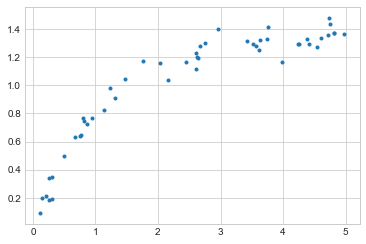

In [4]:
plt.scatter(data.x, data.y, marker='.')
None

## Model

We will model the data so that the $x$ values cummulatively apply an effect to the outcome, so that the largest $x$ value corresponds to a maximum effect:

$$ y_i = a + b\sum_{j=1}^i\delta_j$$

$$ \sum_{j=1}^{N}\delta_j = 1 $$

Here, $y_0 = a$ corresponds to $\min(x)$ and $y_{N-1} = b$ to ${\max(x)}$. 

For $\delta$, luckily, we have a distribution that satisfies exactly that criterion:



$$ \delta \sim \text{Dirichlet}(a=\mathbf{1}) $$

where we set the concentration parameter $a=\mathbf{1}$, which is considered to be non-informative prior.

Choosing priors, we can select a weakly informative prior for a:

$$ a \sim \text{Normal}(0, 0.5^2) $$

For $b$, however, we should select a prior that is strictly positive, because we model growth:

$$ b \sim \text{HalfNormal}(1^2) $$

For the observed data, we will use normal likelihood with Cauchy prior for the noise:

$$ \text{observed} \sim \text{Normal}(y, \varepsilon^2) $$

$$ \varepsilon \sim \text{HalfCauchy}(\beta=1) $$

In [5]:
with pm.Model() as m1:
    N = data.shape[0]

    a = pm.Normal('a', 0, 0.5)
    b = pm.HalfNormal('b', 1)
    delta = pm.Dirichlet('delta', np.ones(N-1))

    _cur = 0
    partial_sum = [0]
    for i in range(N-1):
        _cur = _cur + delta[i]
        partial_sum.append(_cur)

    partial_sum = pm.Deterministic('partial_sum', pm.math.stack(partial_sum))

    y = pm.Deterministic('y', a + b * partial_sum)

    eps = pm.HalfCauchy('eps', beta=1)
    obs = pm.Normal('obs', y, eps,
                    observed=data.y.values)

    m1.trace = pm.sample(5000, tune=5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, delta, b, a]
Sampling 2 chains, 2 divergences: 100%|██████████| 20000/20000 [04:53<00:00, 37.63draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Notice how the $x$ values are not used in the inference, the only thing that matters is their order, that is, $x_i < x_{i+1} $ for all.

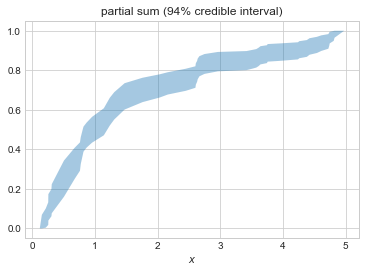

In [6]:
tmp = pd.DataFrame(m1.trace['partial_sum']).apply(pm.hpd).T
plt.fill_between(data.x, tmp[0], tmp[1], alpha=.4)
plt.gca().set(title='partial sum (94% credible interval)',
              xlabel='$x$')
None

Note that the beginning and the end of the partial sum values are exactly 0 and 1, respectively, by design.

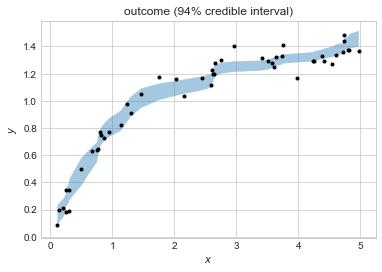

In [7]:
tmp = pd.DataFrame(m1.trace['y']).apply(pm.hpd).T
plt.fill_between(data.x, tmp[0], tmp[1], alpha=.4)
plt.scatter(data.x, data.y, marker='.', color='k')
plt.gca().set(title='outcome (94% credible interval)',
              xlabel='$x$', ylabel='$y$')
None

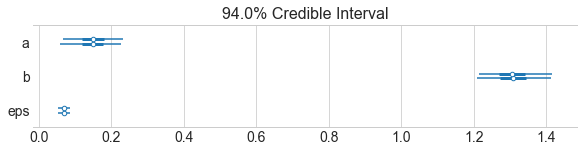

In [8]:
pm.plot_forest(m1.trace, var_names=['a', 'b', 'eps'], figsize=(8, 2))
None